#Telecom X - Análisis de Evasión de Clientes
**Autor: **Alexander Jamin Julon Mayta
**Fecha:** 02/08/2025

Resumen: Este análisis tiene como objetivo ayudar al Sr. Juan a decidir cuál de sus cuatro tiendas de la cadena Alura Store debería vender para iniciar un nuevo emprendimiento. A través del estudio de métricas clave como ingresos, volumen de ventas, reseñas de clientes y eficiencia logística, se identifican las fortalezas y debilidades de cada tienda. El análisis se apoya en visualizaciones claras y concluye con una recomendación basada en datos.

#📌 Extracción

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

archivo = 'https://github.com/AlekJulM/TelecomX_Data-science-LATAM/raw/refs/heads/main/TelecomX_Data.json'
datos = pd.read_json(archivo)


#🔧 Transformación

In [65]:
#normalización de columnas con estructuras anidadas
columnas_json = datos.columns[2:]

df_final = pd.concat([
    datos.drop(columns=columnas_json),
    *[
        pd.json_normalize(datos[col])
        for col in columnas_json
    ]
], axis=1)
df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [66]:
#Cuando los meses de contrato son 0, el cargo total es un espacio vacio, se remplazara por 0
df_final[df_final['Charges.Total'] == ' '][['tenure','Charges.Total']]
df_final['Charges.Total'] = df_final['Charges.Total'].str.replace(' ', '0')
df_final['Charges.Total'] = df_final['Charges.Total'].astype(np.float64)

In [67]:
#conviertiendo tipo de datos object a int
df_final['Partner'] = df_final['Partner'].replace({'Yes': 1, 'No': 0})
df_final['Partner'] = df_final['Partner'].astype('Int8')
df_final['Dependents'] = df_final['Dependents'].replace({'Yes': 1, 'No': 0})
df_final['Dependents'] = df_final['Dependents'].astype('Int8')
df_final['PhoneService'] = df_final['PhoneService'].replace({'Yes': 1, 'No': 0})
df_final['PhoneService'] = df_final['PhoneService'].astype('Int8')

/tmp/ipython-input-2431330518.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['Partner'] = df_final['Partner'].replace({'Yes': 1, 'No': 0})
/tmp/ipython-input-2431330518.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['Dependents'] = df_final['Dependents'].replace({'Yes': 1, 'No': 0})
/tmp/ipython-input-2431330518.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To o

In [68]:
#Creación de columa de tarifa diaria
df_final['Cuentas_Diarias'] = df_final['Charges.Monthly'] / 30
df_final.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


In [86]:
#Valores faltantes
df_final['Churn'].value_counts()
a = len(df_final[df_final['Churn']== ''])/len(df_final)
a = round(a*100)
print(f"Se registra un {a} % de valores faltantes en la columna 'Churn'")

Se registra un 3% de valores faltantes en la columna 'Churn'


In [93]:
#Dado que el 3% es menos del umbral aceptable de valores faltantes, se optará por eliminar dichos registros
df_final['Churn'] = df_final['Churn'].replace({'Yes' : 1, 'No': 0, '': pd.NA})
df_final['Churn'].unique()
df_limpio = df_final.dropna(subset=['Churn'])
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   int64  
 4   Partner           7043 non-null   Int8   
 5   Dependents        7043 non-null   Int8   
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   Int8   
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 
 17  

#📊 Carga y análisis

In [132]:
df_limpio.describe()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7043.000000,7043.0,7043.0,7043.000000,7043.0,7043.000000,7043.000000,7043.000000
mean,0.162147,0.483033,0.299588,32.371149,0.903166,64.761692,2279.734304,2.158723
std,0.368612,0.499748,0.45811,24.559481,0.295752,30.090047,2266.794470,1.003002
min,0.000000,0.0,0.0,0.000000,0.0,18.250000,0.000000,0.608333
25%,0.000000,0.0,0.0,9.000000,1.0,35.500000,398.550000,1.183333
50%,0.000000,0.0,0.0,29.000000,1.0,70.350000,1394.550000,2.345000
75%,0.000000,1.0,1.0,55.000000,1.0,89.850000,3786.600000,2.995000
max,1.000000,1.0,1.0,72.000000,1.0,118.750000,8684.800000,3.958333


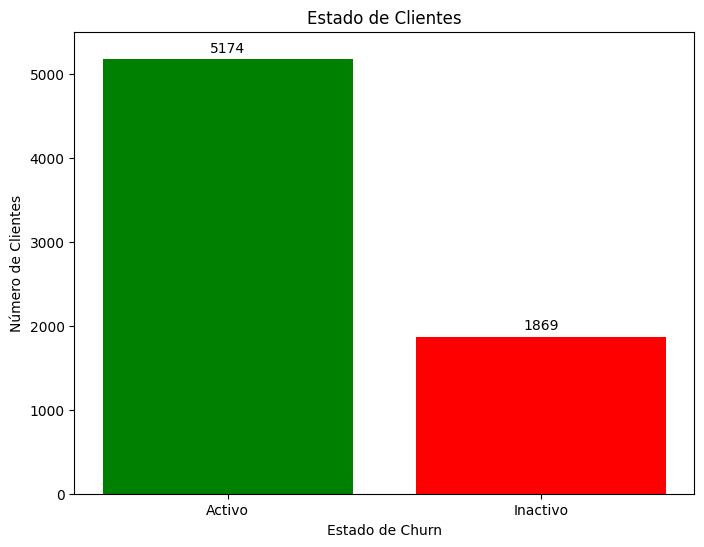

In [142]:
# Gráfico comparativo de clientes
churn_counts = df_limpio['Churn'].value_counts().sort_index()  # ordenar por índice

plt.figure(figsize=(8, 6))
bars = plt.bar(['Activo', 'Inactivo'],
               churn_counts.values,
               color=['green', 'red'])
plt.title('Estado de Clientes')
plt.ylabel('Número de Clientes')
plt.ylim(0,5500)
plt.xlabel('Estado de Churn')

# Agregar valores encima de las barras
for bar, value in zip(bars, churn_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             str(value), ha='center', va='bottom')

plt.show()

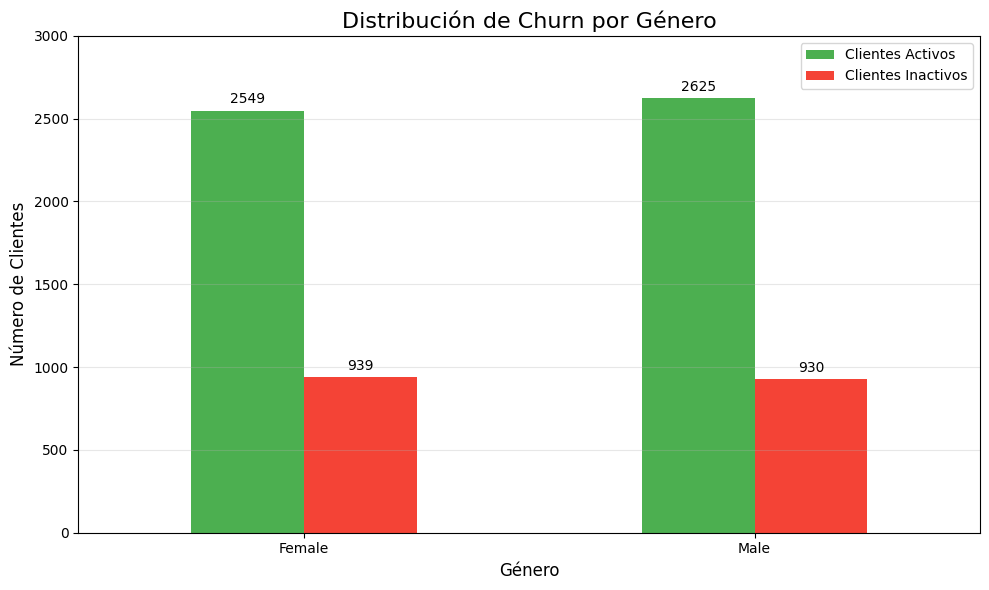

In [134]:
]# Tabla cruzada
churn_gender = pd.crosstab(df_limpio['gender'], df_limpio['Churn'])

# Gráfico
ax = churn_gender.plot(kind='bar',
                       color=['#4CAF50', '#F44336'],
                       figsize=(10, 6))
plt.title('Distribución de Churn por Género', fontsize=16)
plt.xlabel('Género', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.ylim(0,3000)
plt.xticks(rotation=0)
plt.legend(['Clientes Activos', 'Clientes Inactivos'])
plt.grid(axis='y', alpha=0.3)

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.tight_layout()
plt.show()

#📄Informe final